# Homework 2:
Duo Xu

## 1. Finding 100-days signals

In [1]:
import numpy as np
from scipy import optimize as opt
import matplotlib.pyplot as plt
import pickle

with open("data.pkl", "rb") as handle:
    data = pickle.load(handle).T

Define loglikelihood function to maximize (Note: the function below is in fact the negative loglikelihood since we use scipy.optimize.minimize). 

The sinusoidal signal is treated as the mean using 

$$ B + A1\cos(2\pi\frac{t}{100}) + A2\cos(2\pi\frac{t}{100}) $$

In [2]:
def mu1(t, B, A1, A2):
    return B + A1*np.cos(2*np.pi*t/100) + A2*np.sin(2*np.pi*t/100)

def loglike1(t, paras, data, info):
    B, A1, A2 = paras
    y = data
    sigma = info
    temp = y - mu1(t, B, A1, A2)
    summ = np.sum(temp**2/sigma)
    return 0.5*summ

def bestfit1(t, data, info):
    def ll(paras):
        return loglike1(t, paras, data, info)
    x0 = [0,0,0]
    return opt.minimize(ll, x0).x, opt.minimize(ll, x0).hess_inv

In [3]:
bestfits1 = []
covs = []
sigmaBs = np.empty(11)
sigmaA1s = np.empty(11)
sigmaA2s = np.empty(11)
for i in range(2, 13):
    bestfits1.append(bestfit1(data[0], data[i], data[1])[0])
    covs.append(bestfit1(data[0], data[i], data[1])[1])
    sigmaBs[i-2] = (covs[i-2][0][0]**0.5)
    sigmaA1s[i-2] = (covs[i-2][1][1]**0.5)
    sigmaA2s[i-2] = (covs[i-2][2][2]**0.5)

Y1 = np.empty(11)
sigmaY1 = np.empty(11)
B = np.empty(11)
for i in range(2, 13):
    Y1[i-2] = np.sqrt(bestfits1[i-2][1]**2 + bestfits1[i-2][2]**2)
    sigmaY1[i-2] = np.sqrt(sigmaA1s[i-2]**2*(bestfits1[i-2][1]/Y1[i-2])**2 + 
           sigmaA2s[i-2]**2*(bestfits1[i-2][2]/Y1[i-2])**2)
    B[i-2] = bestfits1[i-2][0]

sigfound1 = np.empty(11)
for i in range(11):
    if Y1[i] - 4*sigmaY1[i] > 0:
        sigfound1[i] = True
        print('Found a 100-days period signal in data set ' +
              str(i+1) + ' with amplitude ' + str(Y1[i]))
    else:
        sigfound1[i] = False   
    
sigfoundB = np.empty(11)
for i in range(11):
    if B[i] - 4*sigmaBs[i] > 0:
        sigfoundB[i] = True
        print('Found a DC-level in data set ' +
              str(i+1) + ' of ' + str(B[i]))
    else:
        sigfoundB[i] = False  

Found a 100-days period signal in data set 4 with amplitude 0.3181595758307525
Found a 100-days period signal in data set 5 with amplitude 0.9771593431939868
Found a 100-days period signal in data set 6 with amplitude 3.008707718864154
Found a 100-days period signal in data set 9 with amplitude 0.31426117005440674
Found a 100-days period signal in data set 10 with amplitude 0.9840540362299994
Found a 100-days period signal in data set 11 with amplitude 3.070826426791578
Found a DC-level in data set 2 of 0.28509248640885887
Found a DC-level in data set 4 of 0.5283690812161248
Found a DC-level in data set 6 of 0.45731353021460414
Found a DC-level in data set 7 of 0.48586101186249
Found a DC-level in data set 8 of 0.487965611044675
Found a DC-level in data set 9 of 0.2841235813403242
Found a DC-level in data set 10 of 0.3788664970739754


Since we maximize the log likelihood function and believe in the gaussian uncertainties of our data 100%, the covariance matrix is given by the inverse of the Hessian from scipy.optimize.minimize. From which we can read off the uncertainties in each fitting parameter.

Convert A1 and A2 into A by $ A = \sqrt{A1^2 + A2^2} $ and $\sigma_A^2 = (\frac{dA}{dA1})^2\sigma_{A1}^2 + (\frac{dA}{dA2})^2\sigma_{A2}^2 $ in the high signal-to-noise limit.

Using the threshold of 4 sigmas to claim a discovery of the 100-days signals and DC-levels. We found 100-days signals in data sets 4, 5, 6, 9, 10, 11 and DC-levels in data sets 2, 4, 6, 7, 8, 9, 10.

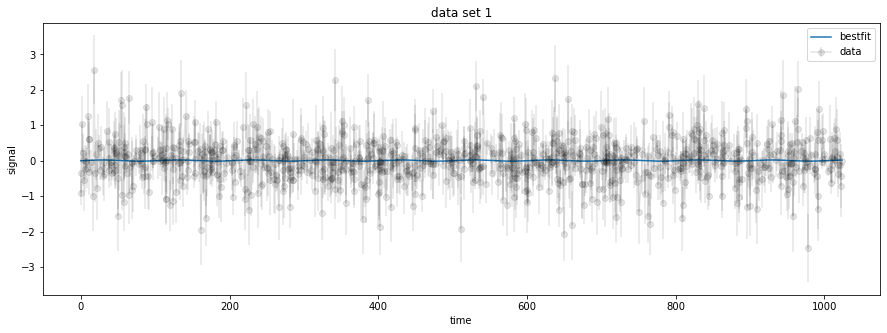

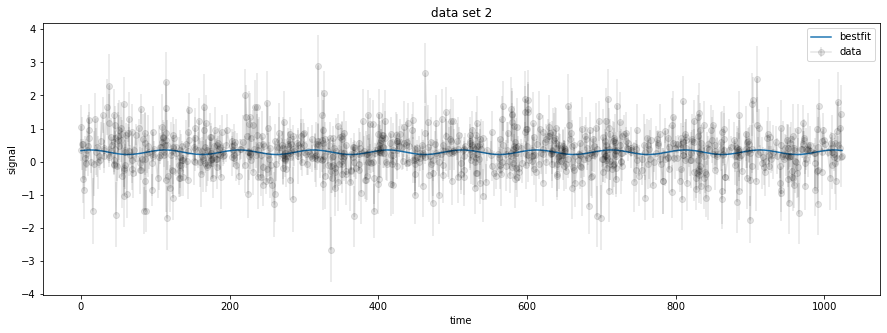

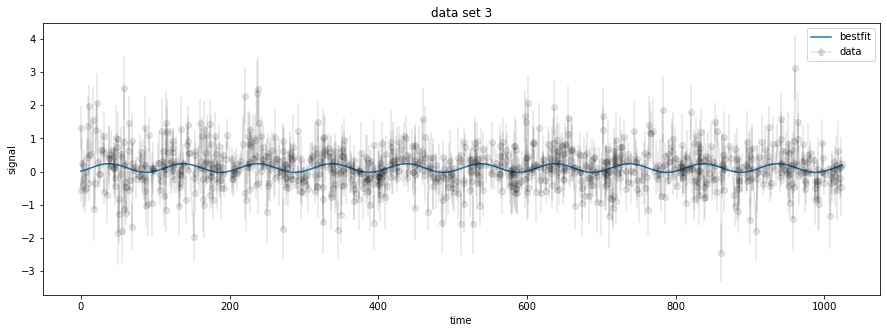

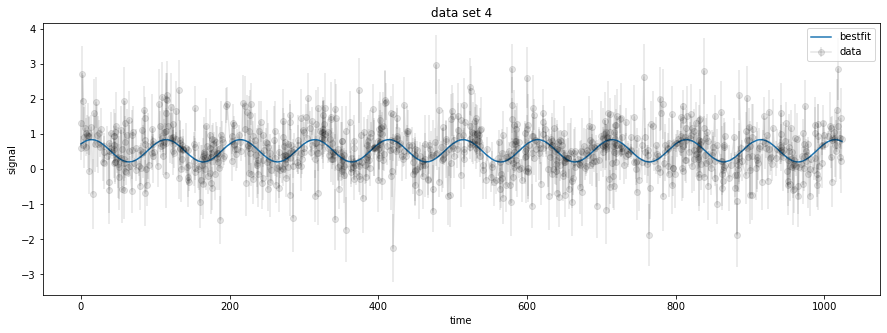

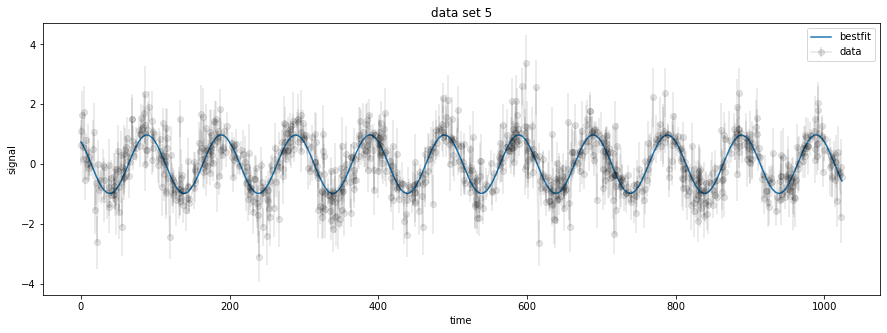

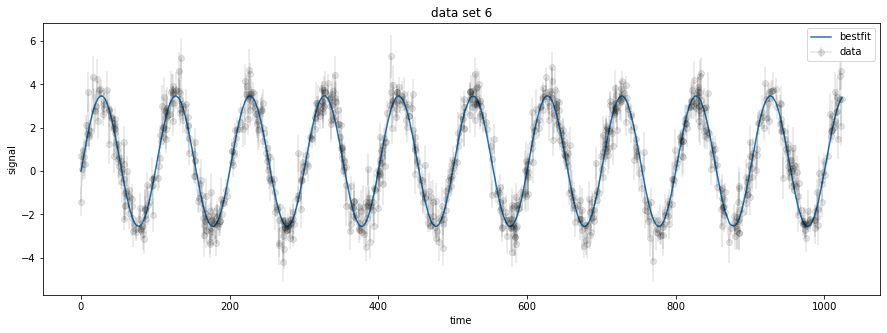

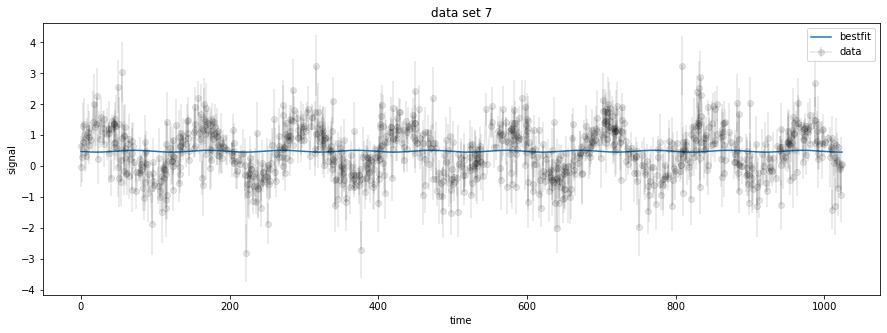

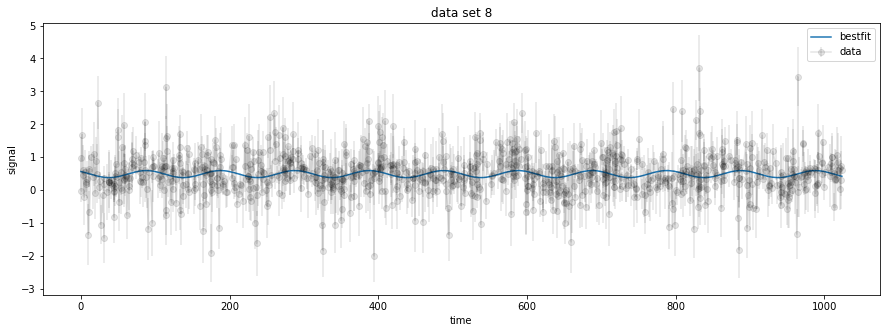

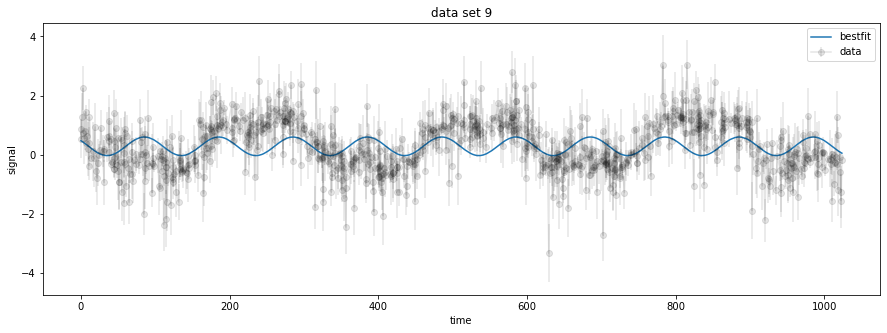

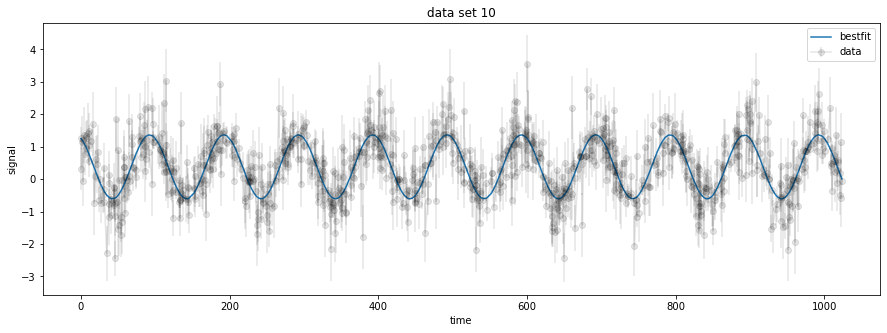

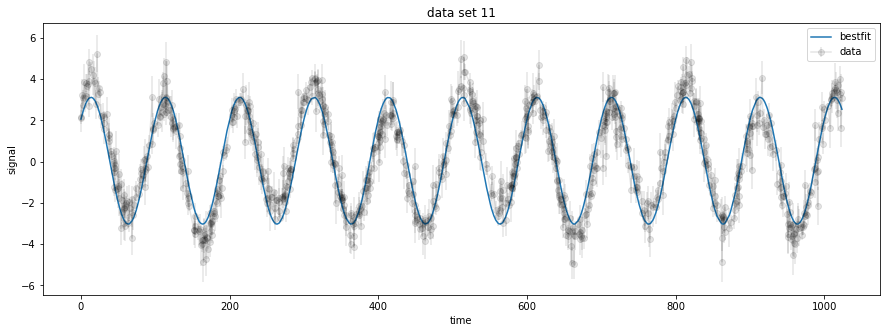

In [4]:
for i in range(2, 13):
    plt.figure(figsize=(15, 5))
    plt.errorbar(data[0], data[i], yerr=data[1],
                 color="k", marker="o", alpha=0.1, label = 'data')
    plt.plot(data[0], mu1(data[0], *bestfits1[i-2]), label = 'bestfit')
    plt.xlabel("time")
    plt.ylabel("signal")
    plt.title("data set {}".format(i-1))
    plt.legend()

## 2. and 3. Finding other signals of differenct periods and treating them as nuisances

Define loglikelihood function to maximize (Note: the function below is in fact the negative loglikelihood since we use scipy.optimize.minimize). 

The sinusoidal signal is treated as the mean using 

$$ B + A1\cos(2\pi\frac{t}{100}) + A2\cos(2\pi\frac{t}{100}) + A3\cos(2\pi\frac{t}{T}) + A4\cos(2\pi\frac{t}{T})$$

Here four of the fitting parameters are linear and one ($T$) is nonlinear. By profiling out the four linear parameters, we obtain the loglikelihood function as the function of $T$ only. The period ($T_{max}$) that maximizes the loglikelihood function is the period of the new sinusoidal signal.

In [5]:
def mu(t, B, A1, A2, A3, A4, T):
    return (B + A1*np.cos(2*np.pi*t/100) + A2*np.sin(2*np.pi*t/100) +
            A3*np.cos(2*np.pi*t/T) + A4*np.sin(2*np.pi*t/T))
    
def loglike(t, paras, data, info):
    B, A1, A2, A3, A4, T = paras
    y = data
    sigma = info
    temp = y - mu(t, B, A1, A2, A3, A4, T)
    summ = np.sum(temp**2/sigma)
    return -0.5*summ

def llt(T, t, paras, data, info):
    B, A1, A2, A3, A4 = paras
    y = data
    sigma = info
    temp = y - mu(t, B, A1, A2, A3, A4, T)
    summ = np.sum(temp**2/sigma)
    return 0.5*summ

def fitT(T, t, data, info):
    def ll(paras):
        return llt(T, t, paras, data, info)
    x0 = [1,1,1,1,1]
    return opt.minimize(ll, x0).x

In [6]:
T = np.linspace(50, 800, 64)
val = []
maxT = []
for j in range(2, 13):
    val.append([])
    for i in range(len(T)):
        paras = fitT(T[i], data[0], data[j], data[1])
        val[j-2].append(loglike(data[0], [paras[0], paras[1], paras[2], paras[3], 
                                paras[4], T[i]], data[j], data[1]))
    maxind = val[j-2].index(max(val[j-2]))
    maxT.append(T[maxind])

def bestfit(T, t, data, info):
    def ll(paras):
        return llt(T, t, paras, data, info)
    x0 = [1,1,1,1,1]
    return opt.minimize(ll, x0).x, opt.minimize(ll, x0).hess_inv

In [7]:
bfs = []
covs = []
sigmaBs = np.empty(11)
sigmaA1s = np.empty(11)
sigmaA2s = np.empty(11)
sigmaA3s = np.empty(11)
sigmaA4s = np.empty(11)
sigmaTs = np.empty(11)
for i in range(2,13):
    bfs.append(bestfit(maxT[i-2], data[0], data[i], data[1])[0])
    covs.append(bestfit(maxT[i-2], data[0], data[i], data[1])[1])
    sigmaBs[i-2] = (covs[i-2][0][0]**0.5)
    sigmaA1s[i-2] = (covs[i-2][1][1]**0.5)
    sigmaA2s[i-2] = (covs[i-2][2][2]**0.5)
    sigmaA3s[i-2] = (covs[i-2][3][3]**0.5)
    sigmaA4s[i-2] = (covs[i-2][4][4]**0.5)

In [8]:
Y1 = np.empty(11)
Y2 = np.empty(11)
B = np.empty(11)
sigmaY1 = np.empty(11)
sigmaY2 = np.empty(11)
for i in range(2, 13):
    Y1[i-2] = np.sqrt(bfs[i-2][1]**2 + bfs[i-2][2]**2)
    Y2[i-2] = np.sqrt(bfs[i-2][3]**2 + bfs[i-2][4]**2)
    sigmaY1[i-2] = np.sqrt(sigmaA1s[i-2]**2*(bfs[i-2][1]/Y1[i-2])**2 + 
           sigmaA2s[i-2]**2*(bfs[i-2][2]/Y1[i-2])**2)
    sigmaY2[i-2] = np.sqrt(sigmaA3s[i-2]**2*(bfs[i-2][3]/Y1[i-2])**2 + 
           sigmaA4s[i-2]**2*(bfs[i-2][4]/Y2[i-2])**2)
    B[i-2] = bfs[i-2][0]

In [9]:
sigfound1 = np.empty(11)
sigfound2 = np.empty(11)
sigfoundB = np.empty(11)
for i in range(11):
    if Y1[i] - 4*sigmaY1[i] > 0:
        sigfound1[i] = True
        print('Found a 100-days period signal in data set ' +
              str(i+1) + ' with amplitude ' + str(Y1[i]))
    else:
        sigfound1[i] = False
for i in range(11):
    if Y2[i] - 4*sigmaY2[i] > 0:
        sigfound2[i] = True
        print('Found a ' + str(maxT[i]) + '-days period signal in data set ' +
              str(i+1) + ' with amplitude ' + str(Y2[i]))
    else:
        sigfound2[i] = False
for i in range(11):
    if B[i] - 4*sigmaBs[i] > 0:
        sigfoundB[i] = True
        print('Found a DC-level in data set ' +
              str(i+1) + ' of ' + str(B[i]))
    else:
        sigfoundB[i] = False 

Found a 100-days period signal in data set 3 with amplitude 0.13212113501012868
Found a 100-days period signal in data set 4 with amplitude 0.3155823090588616
Found a 100-days period signal in data set 5 with amplitude 0.9787420714785081
Found a 100-days period signal in data set 6 with amplitude 3.0080179181773468
Found a 100-days period signal in data set 9 with amplitude 0.3123228492953638
Found a 100-days period signal in data set 10 with amplitude 0.9854074335696134
Found a 100-days period signal in data set 11 with amplitude 3.013282169127895
Found a 133.33333333333334-days period signal in data set 7 with amplitude 0.7794434362246416
Found a 145.23809523809524-days period signal in data set 8 with amplitude 0.19359648160297974
Found a 288.0952380952381-days period signal in data set 9 with amplitude 0.8214113157089163
Found a 252.38095238095238-days period signal in data set 11 with amplitude 0.827641812556012
Found a DC-level in data set 2 of 0.2861242954967999
Found a DC-level

Similarly, the covariance matrix is given by the inverse of the Hessian from scipy.optimize.minimize. From which we can read off the uncertainties in each fitting parameter.

Using the threshold of 4 sigmas to claim a discovery of the signals and DC-levels. We found 100-days signals in data sets 3, 4, 5, 6, 9, 10, 11, other sinusoidal signals in data sets 7, 8, 9, 11, and DC-levels in data sets 2, 3, 4, 6, 7, 8, 9, 10.

The 100-days signal was initially not claimed in data set 3, however after accounting for another signal with different period it can be claimed using the same threshold of 4 sigmas.

Bestfits of the data are shown below, noticeably the data sets 7, 8, 9 ,11 have received better fits when accounting for another sinusoidal signal of different period.

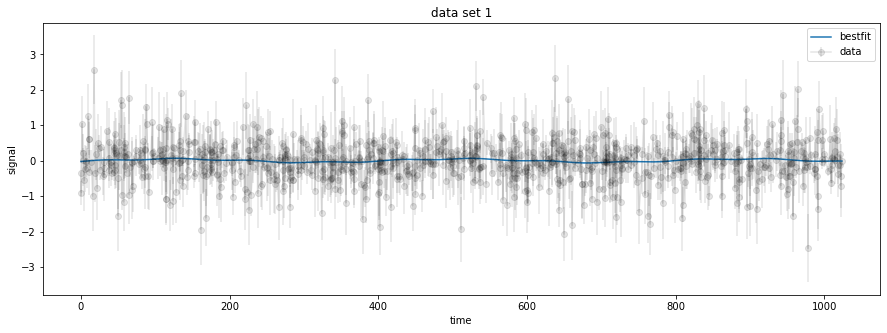

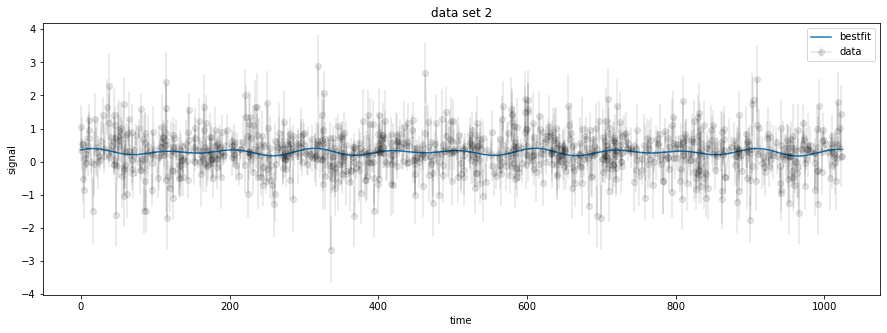

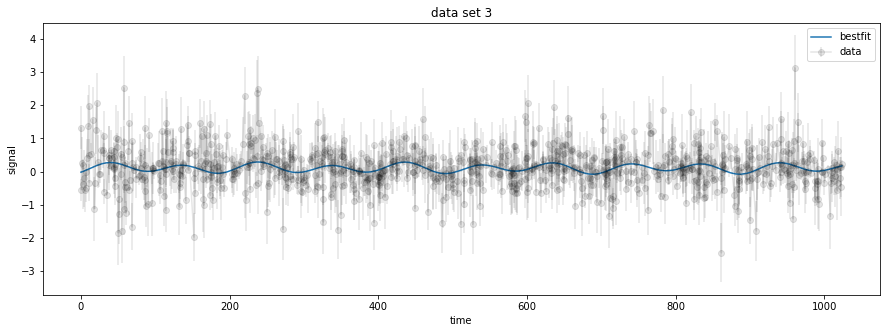

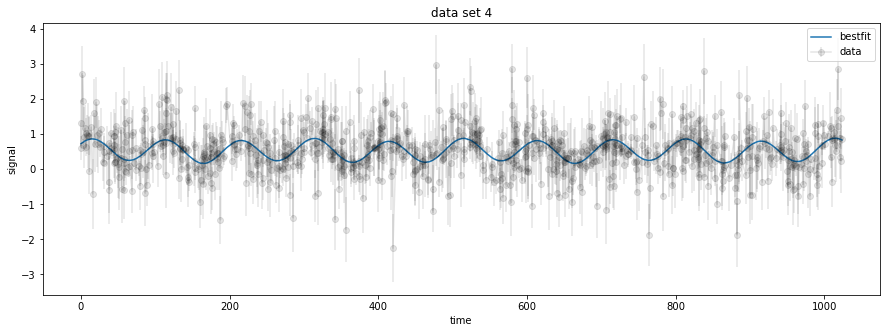

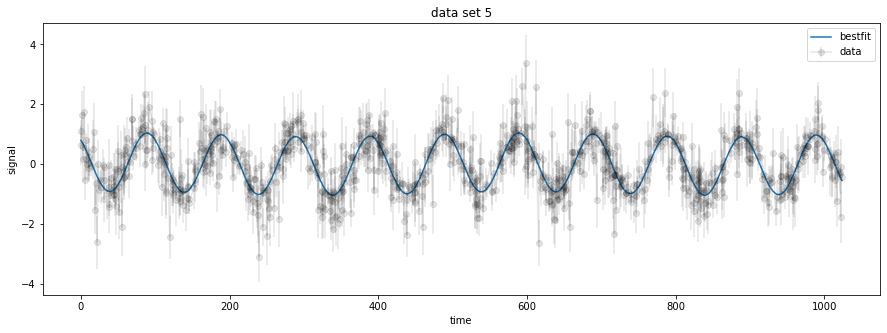

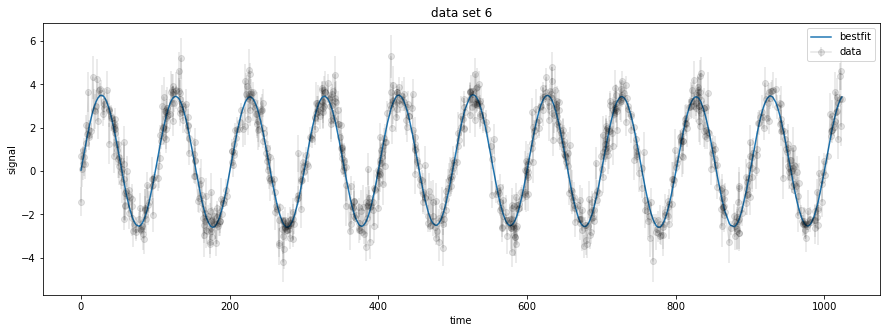

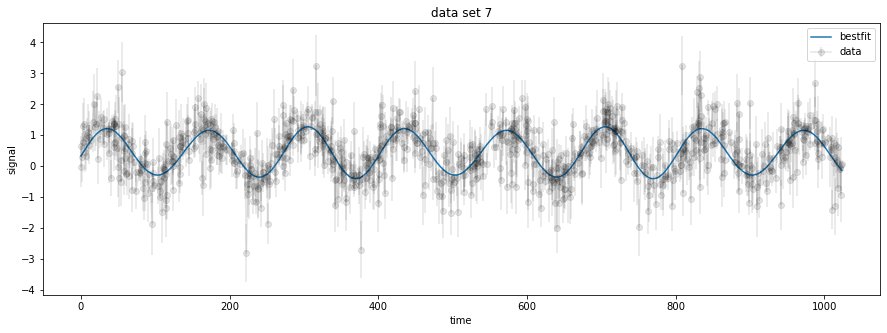

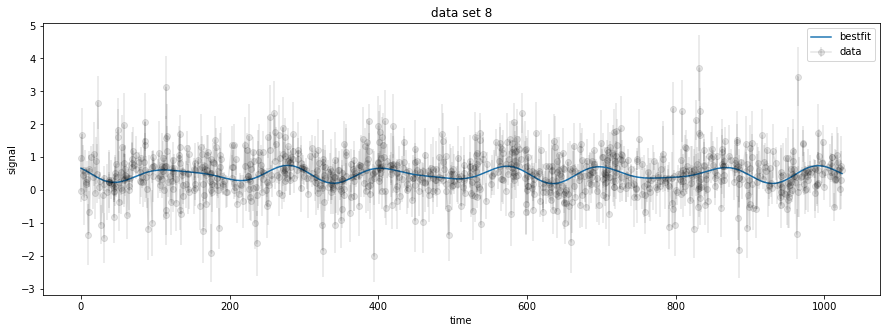

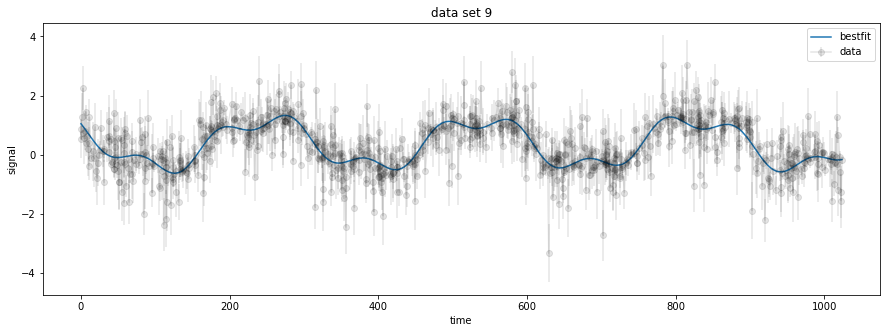

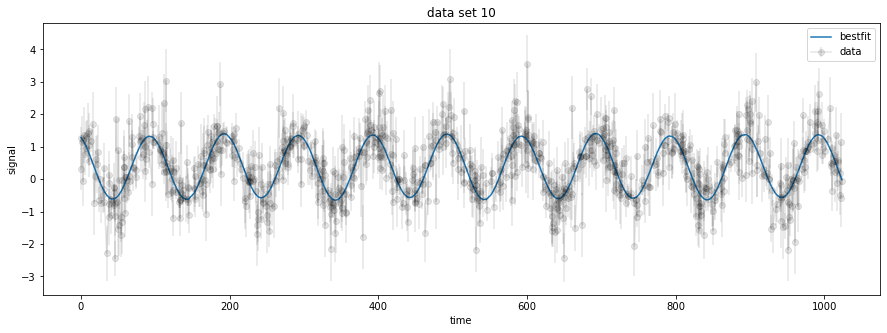

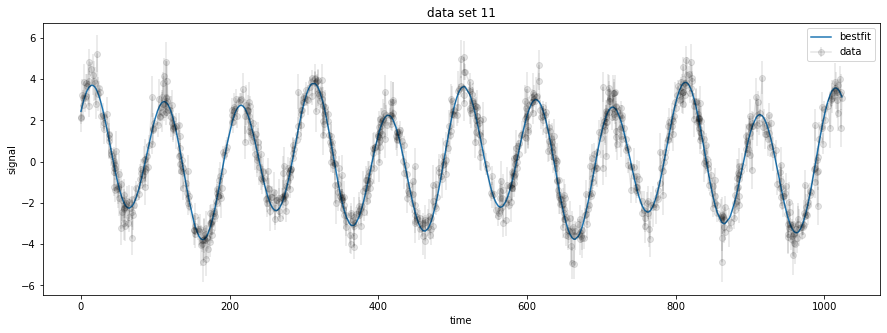

In [10]:
for i in range(2, 13):
    plt.figure(figsize=(15, 5))
    plt.errorbar(data[0], data[i], yerr=data[1],
                 color="k", marker="o", alpha=0.1, label = 'data')
    plt.plot(data[0], mu(data[0], *bfs[i-2], maxT[i-2]), label = 'bestfit')
    plt.xlabel("time")
    plt.ylabel("signal")
    plt.title("data set {}".format(i-1))
    plt.legend()